In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint
import pickle
import glob
import random
from pathlib import Path

import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from utils import utils
import deformation.losses as def_losses
from deformation.semantic_discriminator_loss import SemanticDiscriminatorLoss 
from semantic_discriminator_trainer import train
from deformation.semantic_discriminator_dataset import SemanticDiscriminatorDataset
from deformation.semantic_discriminator_net import SemanticDiscriminatorNetwork

In [4]:
gpu_num = 0
device = torch.device("cuda:"+str(gpu_num))
cfg_path = "configs/testing.yaml"

# Check raw training data images

/home/svcl-oowl/brandon/research/sil_consistent_at_inference/utils/utils.py:52: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg_special = yaml.load(f)
/home/svcl-oowl/brandon/research/sil_consistent_at_inference/utils/utils.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = yaml.load(f)


real_dataset_dir==========================================================
data/semantic_dis_sil/real_renders/983414e34ee6a7966aea2f18ee404fd5_model_7.jpg


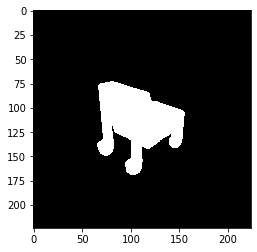

data/semantic_dis_sil/real_renders/96419956c44757fe71a782a4379556c7_model_2.jpg


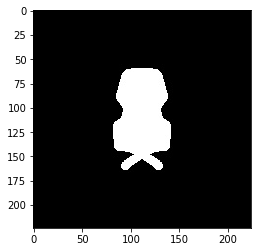

data/semantic_dis_sil/real_renders/31dad882e67008adab1b53c63e6e87b3_model_4.jpg


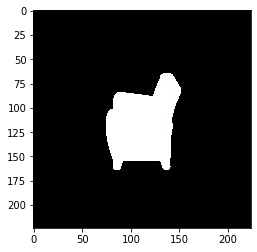

fake_dataset_dir==========================================================
data/semantic_dis_sil/fake_renders/batch_5_of_5_3313_6.jpg


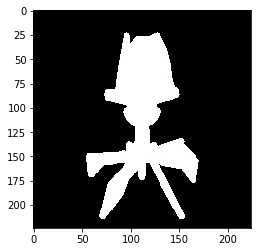

data/semantic_dis_sil/fake_renders/batch_1_of_5_0015_3.jpg


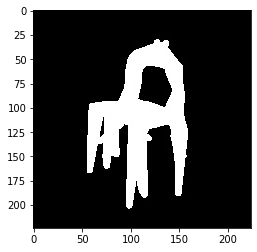

data/semantic_dis_sil/fake_renders/batch_2_of_5_0904_0.jpg


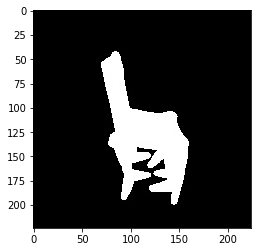

In [5]:
cfg = utils.load_config(cfg_path, "configs/default.yaml")

num_show = 3
for render_dir_type in ["real_dataset_dir", "fake_dataset_dir"]:
    print("{}==========================================================".format(render_dir_type))
    render_dir = os.path.join(cfg["semantic_dis_training"][render_dir_type])
    img_paths = glob.glob(os.path.join(render_dir, "*.jpg"))
    random.shuffle(img_paths)
    for img_path in img_paths[:num_show]:
        print(img_path)
        plt.imshow(cv2.imread(img_path))
        plt.show()

# Check dataloader training data

In [ ]:
dataset = SemanticDiscriminatorDataset(cfg, "train")
print(len(dataset))

In [ ]:
chair_i = 95
#chair_type = "real"
chair_type = "fake"
for i in range(10):
    data_real = dataset[chair_i][chair_type]
    plt.imshow(data_real.permute(1,2,0))
    plt.show()

# View discriminator training statistics

In [ ]:
# show results of experiment
exp_name="2020_08_24--05_31_28_dropout"
#exp_name="2020_08_24--06_45_44_dcgan_dis_drop8"

exp_dir = os.path.join("out", exp_name)
print(exp_dir)
exp_training_info_path = os.path.join(exp_dir, "training_info.p")

exp_training_info = pickle.load(open(exp_training_info_path, "rb"))
exp_training_info['train'].plot.line(x="iteration", y="train_loss")
exp_training_info['val'].plot.line(x="epoch", y="val_acc")

# Check semantic discriminator loss & renders for processed models

In [12]:
#mesh_paths = ["data/test_dataset/0001old.obj"]
mesh_paths = ["data/test_dataset_semantic_discrim/batch_1_of_1/3704.obj"]
#mesh_paths = glob.glob(os.path.join("data/onet_chair_pix3d_dann_simplified_processed/batch_1_of_5","*.obj"))
#mesh_paths = [str(path) for path in list(Path(os.path.join("data/misc/example_shapenet")).rglob('*.obj'))]
#pprint.pprint(mesh_paths)

data/test_dataset_semantic_discrim/batch_1_of_1/3704.obj: 0.24859599769115448
torch.Size([8, 224, 224, 3])


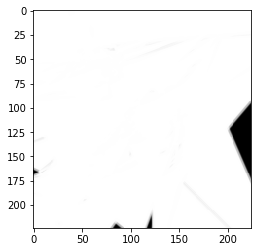

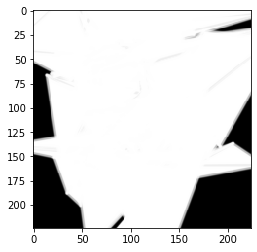

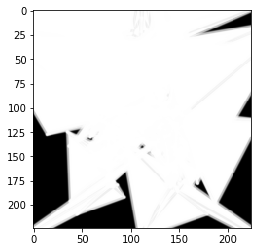

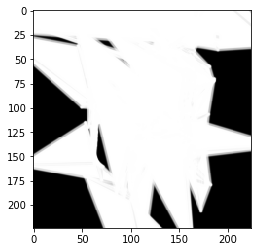

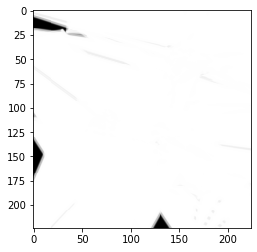

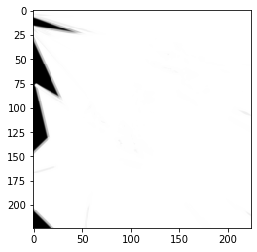

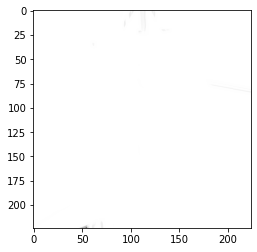

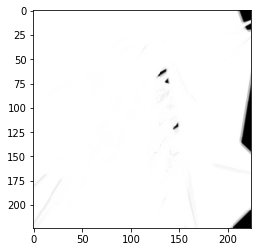

In [13]:
cfg = utils.load_config(cfg_path,"configs/default.yaml")
semantic_loss_computer = SemanticDiscriminatorLoss(cfg, device)

for mesh_path in mesh_paths:
    with torch.no_grad():
        mesh = utils.load_untextured_mesh(mesh_path, device)
        semantic_dis_loss, semantic_loss_renders = semantic_loss_computer.compute_loss(mesh)
    print("{}: {}".format(mesh_path,semantic_dis_loss.item()))
    print(semantic_loss_renders.shape)
    for render in semantic_loss_renders:
        plt.imshow(render.cpu().numpy())
        plt.show()

# Evaluate validation set accuracy from saved weights

In [ ]:
# initalize semantic loss computer and validation set dataloader
cfg = utils.load_config(cfg_path,"configs/default.yaml")
semantic_loss_computer = SemanticDiscriminatorLoss(cfg, device)
val_dataset = SemanticDiscriminatorDataset(cfg, "val")
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, num_workers=4, shuffle=False,
    collate_fn=None, worker_init_fn=None)

In [ ]:
# load model with saved weights
semantic_discriminator_net = SemanticDiscriminatorNetwork(cfg)
semantic_discriminator_net.load_state_dict(torch.load(cfg["training"]["semantic_dis_weight_path"]))
semantic_discriminator_net.to(device)

In [ ]:
# compute validation set accuracy
# TODO: when implemented, use the method in semantic_discriminator_trainer.py instead
val_accuracies = []
n = 100
i = 0
for val_batch in tqdm(val_loader):
    semantic_discriminator_net.eval()
    with torch.no_grad():
        pred_logits_real = semantic_discriminator_net(val_batch['real'].to(device))
        pred_logits_fake = semantic_discriminator_net(val_batch['fake'].to(device))
        batch_size = val_batch['real'].shape[0]
        real_labels = torch.zeros((batch_size, 1)).to(device)
        fake_labels = torch.ones((batch_size, 1)).to(device)     
        real_correct_vec = (torch.sigmoid(pred_logits_real) > 0.5) == real_labels.byte()
        fake_correct_vec = (torch.sigmoid(pred_logits_fake) > 0.5) == fake_labels.byte()
        val_accuracies.append(real_correct_vec.cpu().numpy())
        val_accuracies.append(fake_correct_vec.cpu().numpy())
    val_accuracy = np.mean(np.concatenate(val_accuracies, axis = 0))
    print(val_accuracy)
    i += 1
    if i >= n:
        break
print(val_accuracy)